## 3. Feature Engineering y Selección de Modelo:

### Importo librarías:

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import time
import pickle
import scikitplot as skplt
import shap
import warnings

import sklearn
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, accuracy_score, roc_auc_score, \
                            ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from scipy.stats import randint, uniform
from scipy.sparse import csr_matrix

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Diccionario de Datos

| **Variable**                           | **Descripción**                                                             | **Tipo**    |
|:------------------------------------------:|:---------------------------------------------------------------------------:|:-----------:|
| **fraud_bool (0,1)**                      | Variable objetivo                                                           | int64       |
| **Intented balcon amount**               | Monto transferido inicialmente para una aplicación                         | float64     |
| **prev_address_months_count**             | Número de meses que el solicitante ha vivido en su dirección anterior      | float64     |
| **bank_months_count**                     | Número de meses que el solicitante ha tenido una cuenta bancaria             | float64     |
| **current_address_months_count**          | Número de meses que ha vivido en su dirección actual                        | float64     |
| **session_length_in_minutes**             | Duración de la sesión en minutos                                            | float64     |
| **device_distinct_emails_8w**            | Número de correos electrónicos distintos asociados en las últimas 8 semanas  | float64     |
| **foreign_request**                      | La solicitud proviene de un país extranjero                                  | int64       |
| **phone_mobile_valid**                   | Validación del número de teléfono móvil del solicitante                      | int64       |
| **has_other_cards**                      | El solicitante tiene otras tarjetas de crédito                               | int64       |
| **proposed_credit_limit**                | Límite de crédito propuesto para el solicitante                               | float64     |
| **device_os**                            | Sistema operativo del dispositivo del solicitante                            | object      |
| **source**                               | Origen de la solicitud                                                      | object      |
| **housing_status**                       | Estado de vivienda del solicitante                                          | object      |
| **keep_alive_session**                   | Sesión activa                                                               | float64     |
| **phone_home_valid**                     | Validación del número de teléfono fijo del solicitante                        | int64       |
| **credit_risk_score**                    | Puntaje de riesgo crediticio del solicitante                                 | float64     |
| **email_is_free**                        | Indica si el correo electrónico es gratuito                                  | int64       |
| **income**                               | Ingreso anual del solicitante                                               | float64     |
| **employment_status**                    | Estado laboral del solicitante                                              | object      |
| **date_of_birth_distinct_emails_4w**     | Número de correos electrónicos distintos asociados en las últimas 4 semanas  | float64     |
| **bank_branch_count_8w**                 | Número de sucursales bancarias asociadas en las últimas 8 semanas            | float64     |
| **velocity_4w**                          | Velocidad de solicitudes en las últimas 4 semanas                           | float64     |
| **velocity_24h**                         | Velocidad de solicitudes en las últimas 24 horas                             | float64     |
| **payment_type**                         | Método de pago del cliente                                                  | object      |
| **days_since_request**                   | Número de días transcurridos desde la solicitud                               | float64     |
| **customer_age**                         | Edad del solicitante                                                        | int64       |
| **name_email_similarity**                | Similaridad entre nombre y correo electrónico                                | float64     |
| **month**                                | Mes en el que se realizó la solicitud de crédito                              | int64       |


### Funciones:

In [2]:
import funciones_auxiliares as f_aux

### Lectura de datos:

In [7]:
# Importamos el conjunto de datos tras el análisis exploratorio:
df_fraud = pd.read_csv("../data/df_data_preprocessing_missing_and_outliers.csv").drop("Unnamed: 0", axis = 1)

In [8]:
# Verificamos los variables del conjunto de datos:
df_fraud.columns

Index(['intended_balcon_amount', 'prev_address_months_count',
       'bank_months_count', 'current_address_months_count',
       'session_length_in_minutes', 'device_distinct_emails_8w', 'fraud_bool',
       'foreign_request', 'phone_mobile_valid', 'has_other_cards',
       'proposed_credit_limit', 'device_os', 'source', 'housing_status',
       'keep_alive_session', 'device_fraud_count', 'phone_home_valid',
       'credit_risk_score', 'email_is_free', 'income', 'employment_status',
       'date_of_birth_distinct_emails_4w', 'bank_branch_count_8w',
       'velocity_4w', 'velocity_24h', 'velocity_6h', 'zip_count_4w',
       'payment_type', 'days_since_request', 'customer_age',
       'name_email_similarity', 'month'],
      dtype='object')

In [9]:
# Verificamos el tipo de columnas en el conjunto de datos importado:
df_fraud.dtypes

intended_balcon_amount              float64
prev_address_months_count           float64
bank_months_count                   float64
current_address_months_count        float64
session_length_in_minutes           float64
device_distinct_emails_8w           float64
fraud_bool                            int64
foreign_request                     float64
phone_mobile_valid                  float64
has_other_cards                     float64
proposed_credit_limit               float64
device_os                            object
source                               object
housing_status                       object
keep_alive_session                  float64
device_fraud_count                  float64
phone_home_valid                    float64
credit_risk_score                   float64
email_is_free                       float64
income                              float64
employment_status                    object
date_of_birth_distinct_emails_4w    float64
bank_branch_count_8w            

### Selección de variables:

In [10]:
# Creamos listas de las variables categóricas y numéricas:
categoricals_list = list(df_fraud.select_dtypes("object", "category").columns)
continuous_list = list(set(df_fraud.columns) - set(categoricals_list))

In [11]:
categoricals_list

['device_os', 'source', 'housing_status', 'employment_status', 'payment_type']

In [12]:
# Visualizamos las variables numéricas:
df_fraud[df_fraud[continuous_list] != "fraud_bool"].head(5)

,intended_balcon_amount,prev_address_months_count,bank_months_count,current_address_months_count,session_length_in_minutes,device_distinct_emails_8w,fraud_bool,foreign_request,phone_mobile_valid,has_other_cards,...,bank_branch_count_8w,velocity_4w,velocity_24h,velocity_6h,zip_count_4w,payment_type,days_since_request,customer_age,name_email_similarity,month
0,NaN,NaN,24.0,88.0,3.888115,1.0,1,0.0,0.0,0.0,...,1.0,3863.647740,3134.319630,10650.765523,769.0,NaN,0.020925,50.0,0.166828,7.0
1,NaN,NaN,15.0,144.0,31.798819,1.0,1,0.0,0.0,0.0,...,718.0,3124.298166,2670.918292,534.047319,366.0,NaN,0.005418,50.0,0.296286,7.0
2,NaN,NaN,NaN,132.0,4.728705,1.0,1,0.0,1.0,0.0,...,1.0,3159.590679,2893.621498,4048.534263,870.0,NaN,3.108549,40.0,0.044985,7.0
3,NaN,NaN,31.0,22.0,2.047904,1.0,1,0.0,1.0,1.0,...,1921.0,3022.261812,4054.908412,3457.064063,810.0,NaN,0.019079,50.0,0.159511,7.0
4,NaN,NaN,31.0,218.0,3.775225,1.0,1,0.0,0.0,0.0,...,1990.0,3087.670952,2728.237159,5020.341679,890.0,NaN,0.004441,50.0,0.596414,7.0


In [13]:
# Hacemos un One-Hot Encoding de las variables categóricas para poder usar la función de regresión lineal de Lasso con el
# fin de entender la importancia de cada variable:
ohe = ce.OneHotEncoder(cols = categoricals_list)

model = ohe.fit(df_fraud, df_fraud["fraud_bool"])
model

OneHotEncoder(cols=['device_os', 'source', 'housing_status',
                    'employment_status', 'payment_type'])

In [14]:
# Transformamos las variables categóricas usando el fit y el transform del ColumnTransformer:

ohe_transform = ColumnTransformer(transformers = [('category', OneHotEncoder(), categoricals_list)], 
                                  remainder = 'passthrough')

# Creamos un nuevo dataframe con los datos del one-hot encoding ya que este encoding sirve solamente para poder usar la 
# función de Lasso, de manera controlamos que no se corrompa el dataframe del conjunto de datos original:
df_ohe = pd.DataFrame(ohe_transform.fit_transform(df_fraud),
                      columns = ohe_transform.get_feature_names_out(df_fraud.columns))

In [15]:
# Visualizamos esta nueva tabla con el one-hot encoding:
df_ohe.head()

,category__device_os_linux,category__device_os_macintosh,category__device_os_other,category__device_os_windows,category__device_os_x11,category__source_INTERNET,category__source_TELEAPP,category__housing_status_BA,category__housing_status_BB,category__housing_status_BC,...,remainder__date_of_birth_distinct_emails_4w,remainder__bank_branch_count_8w,remainder__velocity_4w,remainder__velocity_24h,remainder__velocity_6h,remainder__zip_count_4w,remainder__days_since_request,remainder__customer_age,remainder__name_email_similarity,remainder__month
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,6.0,1.0,3863.647740,3134.319630,10650.765523,769.0,0.020925,50.0,0.166828,7.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,3.0,718.0,3124.298166,2670.918292,534.047319,366.0,0.005418,50.0,0.296286,7.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,14.0,1.0,3159.590679,2893.621498,4048.534263,870.0,3.108549,40.0,0.044985,7.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,6.0,1921.0,3022.261812,4054.908412,3457.064063,810.0,0.019079,50.0,0.159511,7.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,2.0,1990.0,3087.670952,2728.237159,5020.341679,890.0,0.004441,50.0,0.596414,7.0


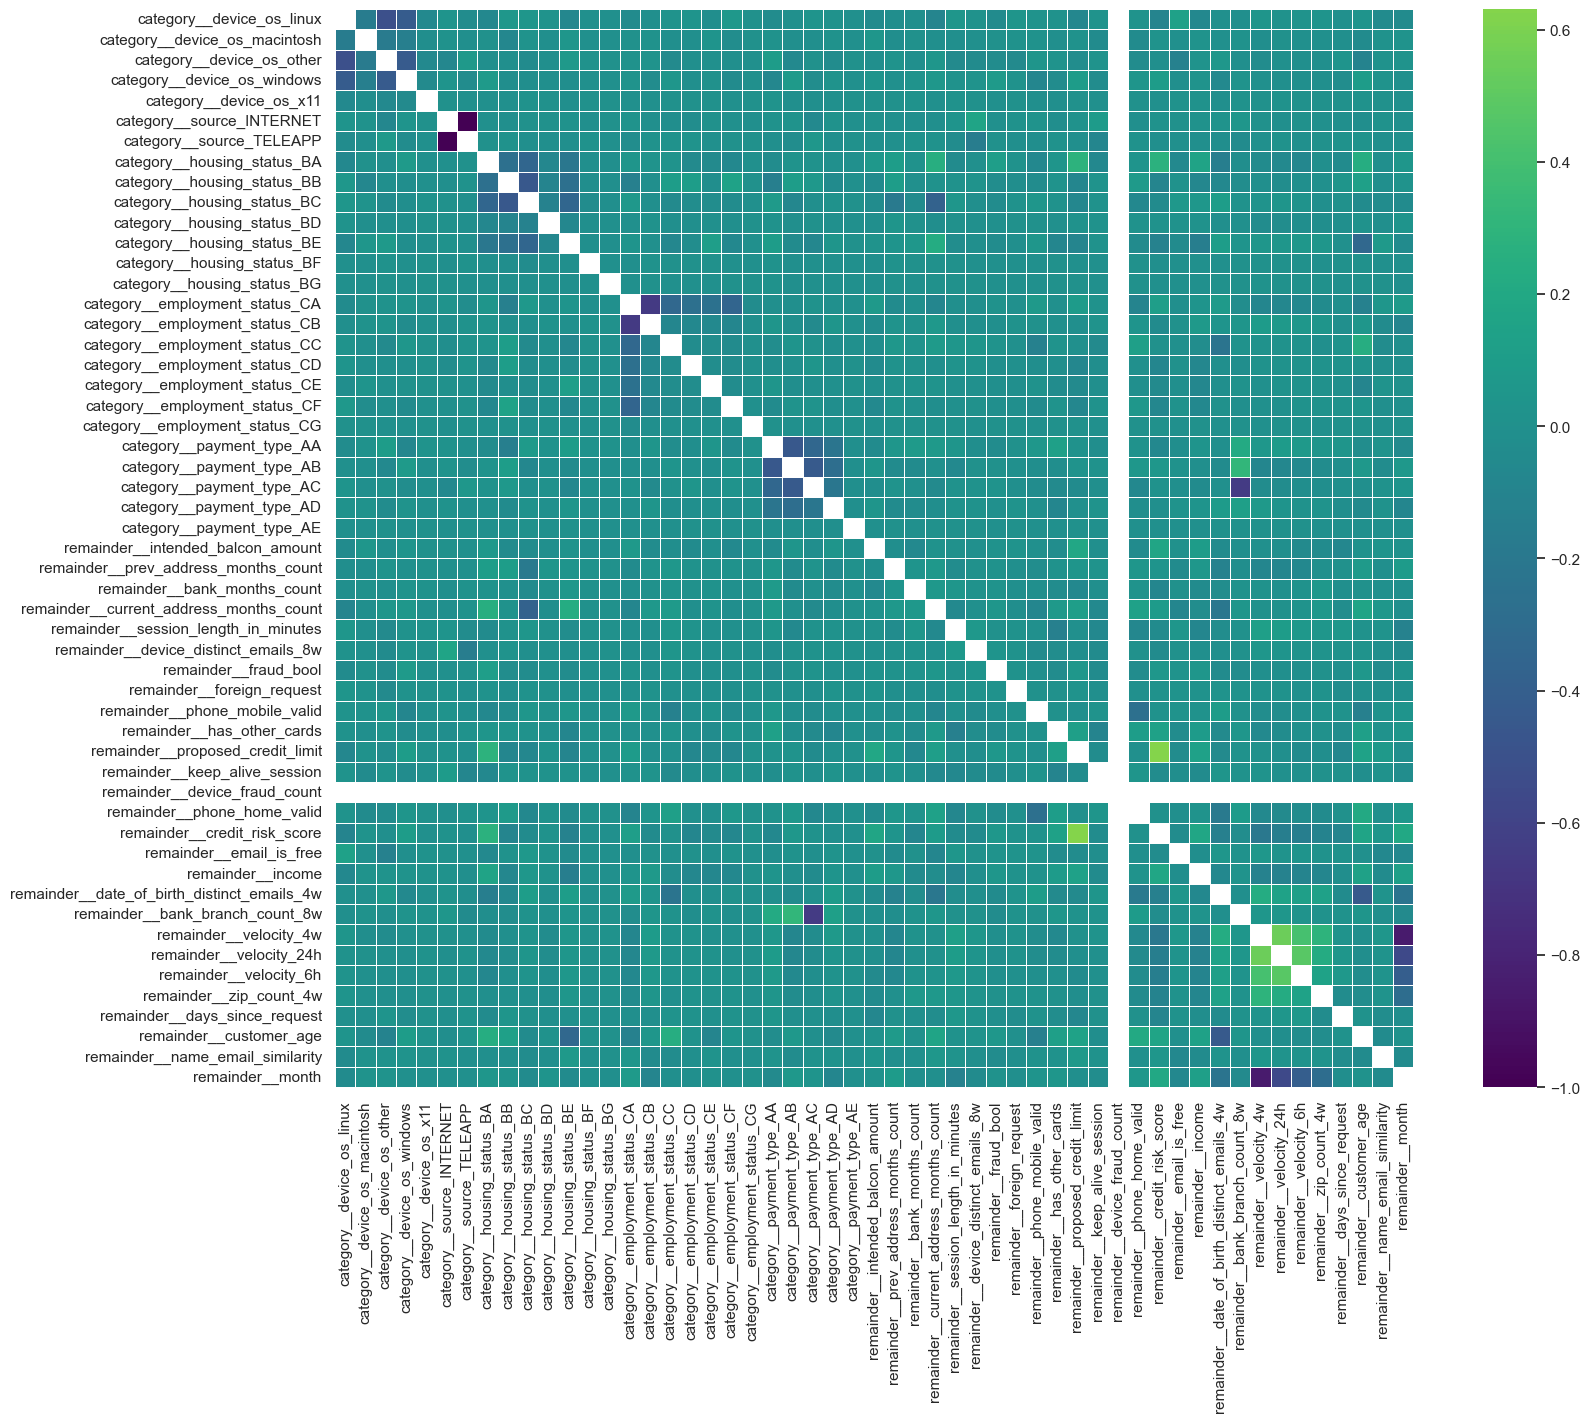

0

In [16]:
# Visualizamos en un gráfico la correlación entre todas las nuevas categorías y las todas las variables numéricas:
f_aux.get_corr_matrix(dataset = df_ohe, metodo = 'spearman', size_figure = [18, 14])

In [17]:
# Visualizamos en una tabla la correlación entre las variables, fijandonos en las variables con más correlación:
corr = df_ohe.corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k = -1) # below main lower triangle of an array
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by = 'correlation', ascending = False)
new_corr[new_corr['correlation'] > 0.4]

,level_0,level_1,correlation
323,category__source_TELEAPP,category__source_INTERNET,1.000000
2749,remainder__month,remainder__velocity_4w,0.848100
809,category__employment_status_CB,category__employment_status_CA,0.659126
2117,remainder__credit_risk_score,remainder__proposed_credit_limit,0.606141
2750,remainder__month,remainder__velocity_24h,0.549919
2437,remainder__velocity_24h,remainder__velocity_4w,0.539115
106,category__device_os_other,category__device_os_linux,0.509894
2490,remainder__velocity_6h,remainder__velocity_24h,0.464003
485,category__housing_status_BC,category__housing_status_BB,0.457492
1187,category__payment_type_AB,category__payment_type_AA,0.452727


Como podemos ver en la tabla de arriba, las categorías de "TELEAPP" y de "INTERNET" de la variable categórica de "source" tienen una correlación de 1. Esto es dado que esta variable esta compuesta de solo estas dos categorías, por lo tanto, al hacer un One-Hot Encoding, con guardar una de las columnas que se generan (la columna de "category__source_TELEAPP" por ejemplo) es suficiente para saber si una fila pertenece a la categoría de TELEAPP o INTERNET. Por esta razón, a continuación eliminamos la columna de "category__source_INTERNET":

In [18]:
print("columns before:", df_ohe.shape[1])
df_ohe = df_ohe.drop("category__source_INTERNET", axis = 1)
print("columns after:", df_ohe.shape[1])

columns before: 53
columns after: 52


En las celdas de abajo usamos la función de Lasso con la intención de solo ver las variables que recomienda eliminar, por lo tanto, como no vamos a usar ningún otro output de la función, no hace falta que separemos los datasets de train, validation y test antes de usar la función.

Es importante mencionar que la función de Lasso no se puede usar con valores nulos, por lo tanto, como nuetro dataset si que contiene valores nulos, usamos un dataset temporario en el que cambiamos todos los nulos a la media de la variable a la q pertenezcan. Este paso no lo hacemos sobre el dataset original de df_fraud dado a que implica hacer cambios significativos antes de la sección de feature engineering.

In [19]:
df_lasso = df_fraud.copy()

df_lasso[continuous_list] = df_lasso[continuous_list].apply(lambda x: x.fillna(x.mean()))

df_ohe_sin_NA = pd.DataFrame(ohe_transform.fit_transform(df_lasso),
                      columns = ohe_transform.get_feature_names_out(df_fraud.columns))
df_ohe_sin_NA = df_ohe_sin_NA.drop("category__source_INTERNET", axis = 1)

# A continuación empleamos la función de Lasso con un alpha de 0.0000001. Hemos llegado a este alpha en específico
# después de haber probado con muchos valores, viendo q justo este valor era el que mejor nos funcionaba:
lasso = Lasso(alpha = 0.0000001)

lasso = lasso.fit(df_ohe_sin_NA, df_ohe_sin_NA["remainder__fraud_bool"])

lasso.coef_

array([-7.51416665e-06, -5.98883960e-07,  2.79543202e-06, -1.69267322e-06,
       -0.00000000e+00, -1.10433967e-05, -1.08327930e-05, -1.26418131e-05,
       -2.36206698e-05, -2.18553993e-05,  2.96189507e-05, -0.00000000e+00,
        0.00000000e+00, -4.52055558e-06,  6.77354922e-06, -2.39655897e-05,
        3.14646996e-06, -1.48095377e-06,  1.02533866e-05, -0.00000000e+00,
       -1.29650775e-05, -2.28350502e-06,  4.44247856e-06,  2.07565501e-06,
        0.00000000e+00, -5.35990364e-07, -8.79294972e-08,  2.01436654e-07,
       -2.85055444e-07, -6.98906181e-07, -0.00000000e+00,  9.99935334e-01,
        2.26220376e-06,  2.00497024e-05, -1.22518545e-05,  3.50583911e-08,
       -3.87473277e-07,  0.00000000e+00, -9.69550571e-06, -1.86152817e-07,
        6.62817572e-06,  7.95892101e-06, -5.31535372e-06,  4.35614877e-09,
       -5.85781232e-09, -3.39709080e-09,  2.87884915e-10,  2.37464254e-09,
       -3.35812153e-07,  5.17988728e-08,  0.00000000e+00, -4.39999378e-06])

Sabemos que variables equivalen a las variables con lasso coeficiente igual a cero ya que el dataset resultante del One Hot Encoding y el array resultante de la función de Lasso comparten las mismas columnas en el mismo orden. Por lo tanto, podemos saber los nombres de las variables con coeficiente Lasso de cero, los cuales describimos en la siguiente celda:

In [20]:
# Visualizamos la importancia asignada a cada variable por la función de Lasso en una tabla llamada df_lasso, viendo a ver 
# que variables son menos significativas para el análisis que veremos a continuación:

lasso_coef = list(lasso.coef_)
ohe_column = list(df_ohe.columns)
df_lasso = pd.DataFrame({"Variable_Name": ohe_column,
                       "Variable_Lasso_Coefficient": lasso_coef})

df_lasso[(df_lasso["Variable_Lasso_Coefficient"] >= -1*(10**-7)) & \
         (df_lasso["Variable_Lasso_Coefficient"] <= 1*(10**-8))] \
        .sort_values(by = "Variable_Lasso_Coefficient", ascending = True)

,Variable_Name,Variable_Lasso_Coefficient
26,remainder__prev_address_months_count,-8.792950e-08
44,remainder__velocity_4w,-5.857812e-09
45,remainder__velocity_24h,-3.397091e-09
4,category__device_os_x11,-0.000000e+00
11,category__housing_status_BF,-0.000000e+00
12,category__housing_status_BG,0.000000e+00
19,category__employment_status_CG,-0.000000e+00
24,category__payment_type_AE,0.000000e+00
30,remainder__device_distinct_emails_8w,-0.000000e+00
37,remainder__device_fraud_count,0.000000e+00


In [21]:
# Visualizamos toda la tabla de df_lasso:
df_lasso = df_lasso[df_lasso["Variable_Name"] != "remainder__fraud_bool"]
df_lasso.sort_values(by = "Variable_Lasso_Coefficient", ascending = True).head(10)

,Variable_Name,Variable_Lasso_Coefficient
15,category__employment_status_CC,-0.000024
8,category__housing_status_BC,-0.000024
9,category__housing_status_BD,-0.000022
20,category__payment_type_AA,-0.000013
7,category__housing_status_BB,-0.000013
34,remainder__has_other_cards,-0.000012
5,category__source_TELEAPP,-0.000011
6,category__housing_status_BA,-0.000011
38,remainder__phone_home_valid,-0.000010
0,category__device_os_linux,-0.000008


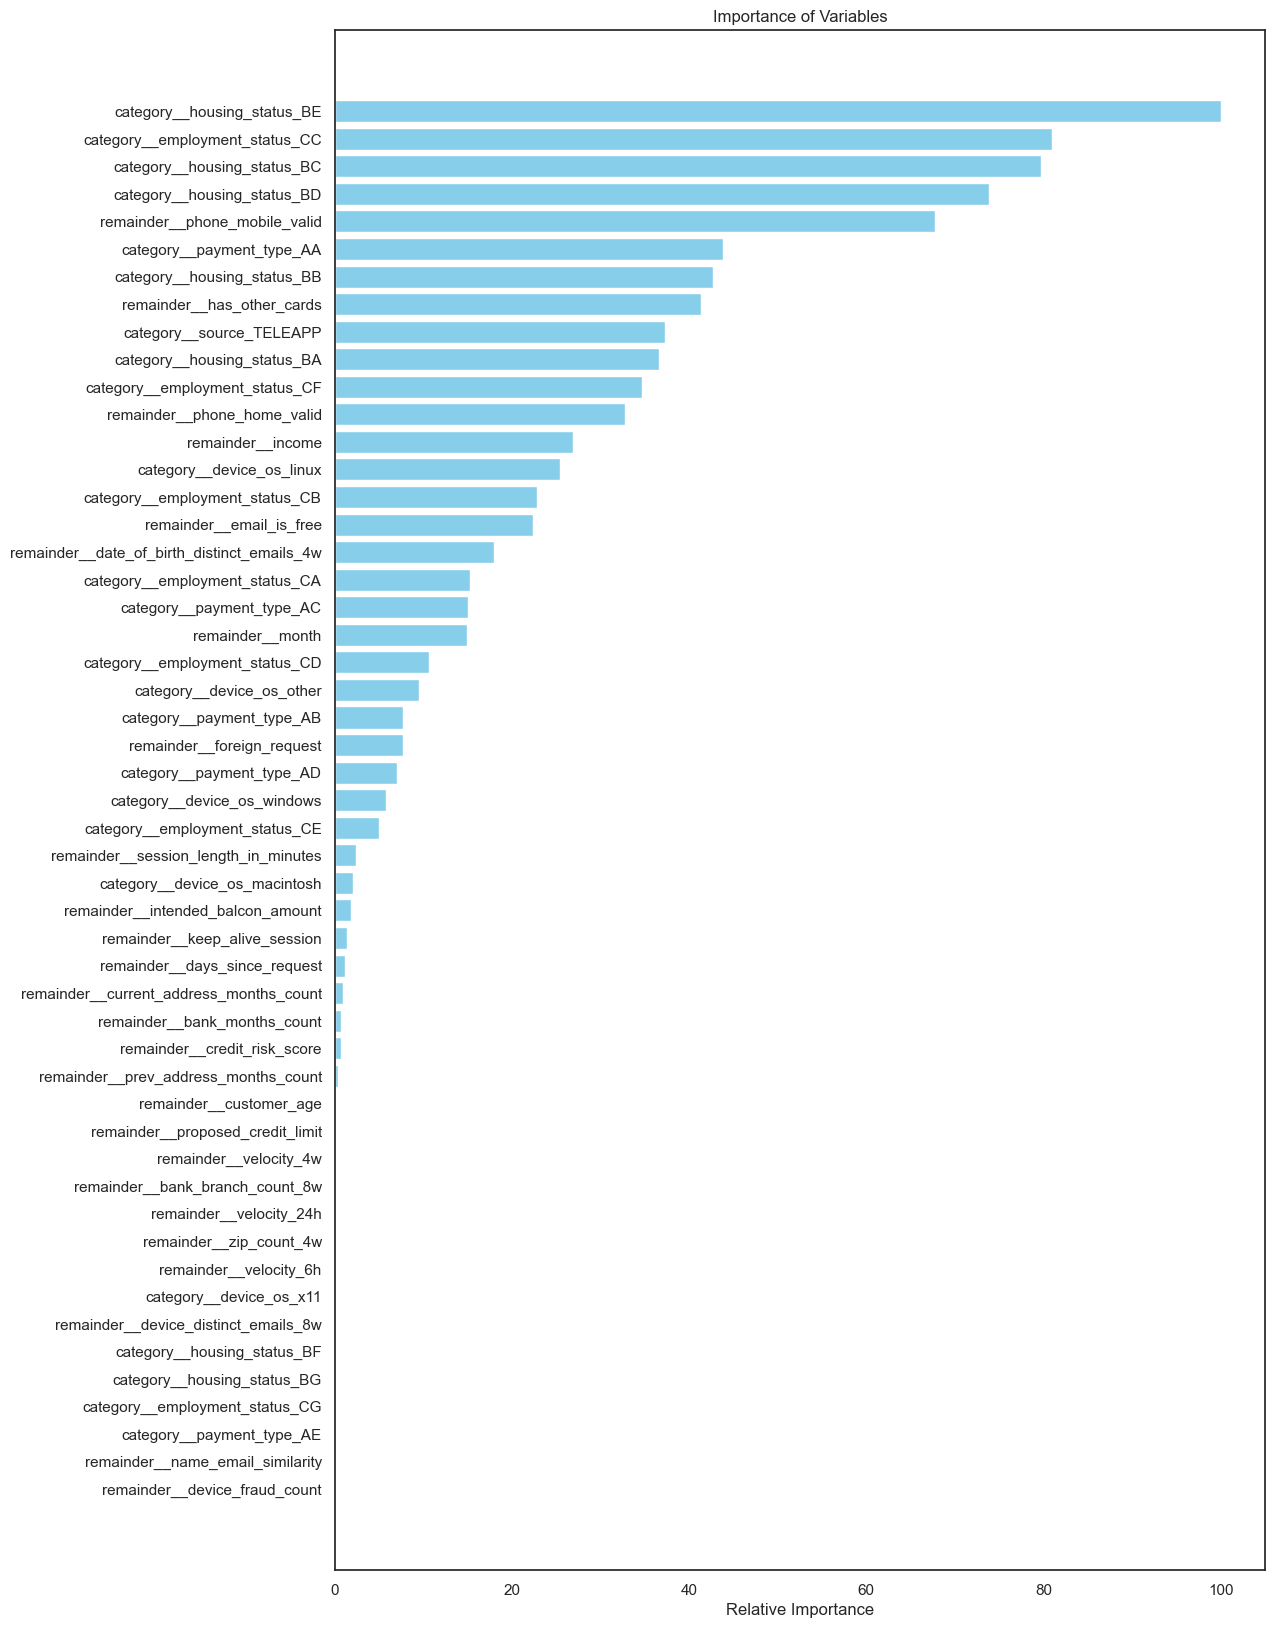

In [22]:
# Visualizamos en un gráfico la importancia global de cada variable (o "feature") relativa a la variable más importante,
# que sería la categoría de "BE" de la variable categórica de "housing_status":

feature_importance = 100.0 * np.abs(df_lasso["Variable_Lasso_Coefficient"]) / df_lasso["Variable_Lasso_Coefficient"].max()
df_lasso["Feature_Importance"] = feature_importance
df_lasso = df_lasso.sort_values(by = "Feature_Importance", ascending = True)

plt.figure(figsize = (12, 20))

plt.barh(df_lasso["Variable_Name"], df_lasso["Feature_Importance"], color = 'skyblue')
plt.xlabel('Relative Importance')
plt.title('Importance of Variables')

plt.show()

In [23]:
# Usando una tabla, visualizamos las variables con menor importancia según la función de Lasso: 
df_lasso[df_lasso["Feature_Importance"] < 1]

,Variable_Name,Variable_Lasso_Coefficient,Feature_Importance
37,remainder__device_fraud_count,0.000000e+00,0.000000
50,remainder__name_email_similarity,0.000000e+00,0.000000
24,category__payment_type_AE,0.000000e+00,0.000000
19,category__employment_status_CG,-0.000000e+00,0.000000
12,category__housing_status_BG,0.000000e+00,0.000000
11,category__housing_status_BF,-0.000000e+00,0.000000
30,remainder__device_distinct_emails_8w,-0.000000e+00,0.000000
4,category__device_os_x11,-0.000000e+00,0.000000
46,remainder__velocity_6h,2.878849e-10,0.000972
47,remainder__zip_count_4w,2.374643e-09,0.008017


Usando el gráfico de arriba, podemos ver que hay variables del conjunto de datos que aportan una importancia relativamente insignificante al hacer un análisis sobre el fraude que existe en los datos. Estas variables son "device_fraud_count", "velocity_6h" y "zip_count_4w".

In [24]:
# Las variables que recomienda elminar la función de Lasso:
lasso_drop_list = ["device_fraud_count", "velocity_6h", "zip_count_4w"]
lasso_drop_list 

['device_fraud_count', 'velocity_6h', 'zip_count_4w']

A continuación, usamos otra función distinta con el mismo fin con el que hemos usado la función de Lasso. Usamos varias funciones para averiguar que variables podemos asignar como insignificantes al análisis del conjunto de datos para de esta manera poder comparar los resultados de cada método y tener una imagen más completa al decidir que variables seleccionamos al pasar al siguiente paso de este análisis. 

Usamos la funcion de "VarianceThreshold" de la libreria de "sklearn.feature_selection" ya que identifica y excluye todos aquellos predictores cuya varianza no supera un determinado threshold porque no es conveniente incluir predictores que tengan una varianza próxima a cero (que tomen solo unos pocos valores, de los cuales, algunos aparezcan con muy poca frecuencia) y que por lo tanto puedan tratarse como con varianza igual a cero cuando se dividan las observaciones por validación cruzada.

In [25]:
# Aplicando la función de VarianceThreshold():
df_continuous = df_fraud.drop(categoricals_list, axis = 1)

model_threshold = VarianceThreshold(threshold = 0.1)

df_threshold = model_threshold.fit_transform(df_continuous)

threshold_columns = df_continuous.columns[model_threshold.get_support()]
threshold_columns = threshold_columns.tolist()

In [26]:
# Creando una lista de las variables que recomienda eliminar la función de VarianceThreshold():
variance_threshold_drop_list = []

for i in continuous_list:
    if i not in threshold_columns and i != "fraud_bool":
        variance_threshold_drop_list.append(i)

variance_threshold_drop_list

['name_email_similarity',
 'device_fraud_count',
 'foreign_request',
 'income',
 'device_distinct_emails_8w',
 'phone_mobile_valid']

In [27]:
lasso_drop_list

['device_fraud_count', 'velocity_6h', 'zip_count_4w']

Teniendo estas dos listas de variables que recomiendan excluir las dos función que hemos usado, podemos comparar y ver que las dos funciones recomiendas excluir la variable de "device_fraud_count" del análisis, pero también que a parte de esta variable, no se ponen de acuerdo con el resto de las variables. Al final, hemos decidido usar la lista que recomienda excluir la función de Lasso, dado que no nos parecía apropiado eliminar seis columnas comor recomienda VarianceThreshold(). Mientras que reducir la dimensionalidad de un conjunto datos tiene muchas ventajas, como reducir el coste computacional de un análisis, nos ha parecido demasiado arriesgado por la posibilidad de estar eliminando variables que contengan información que al final sea útil en el análisis final de fraude. Por lo tanto, hemos optado solo eliminar las tres variables recomendadas por la funcion de Lasso().

In [28]:
# Haciendo la selección final de variales:
df_fraud_final = df_fraud.copy()
df_fraud_final = df_fraud_final.drop(lasso_drop_list, axis = 1)

In [29]:
len(df_fraud_final.columns)

29

### Feature engineering:

In [30]:
# Visualizando la cantidad de nulos, en que variables se encuentran, y si afectan más los datos de fraude o no fraude:
continuous_list = list(set(df_fraud_final.columns) - set(categoricals_list))
f_aux.get_percent_null_values_target(df_fraud_final, continuous_list, target = "fraud_bool")

,sum_null_values,no_fraud,fraud,variable,porcentaje_sum_null_values
0,2015,0.991067,0.008933,session_length_in_minutes,0.002015
1,253635,0.983677,0.016323,bank_months_count,0.253635
2,712920,0.985785,0.014215,prev_address_months_count,0.712920
3,4254,0.996709,0.003291,current_address_months_count,0.004254
4,742523,0.986873,0.013127,intended_balcon_amount,0.742523
5,359,0.988858,0.011142,device_distinct_emails_8w,0.000359


In [31]:
# Volvemos a establecer las listas de variables categóricas y numéricas para que incluyan la variable objetivo:
categoricals_list = list(df_fraud_final.select_dtypes("object", "category").columns)
continuous_list = list(df_fraud_final.select_dtypes("float").columns)

In [32]:
# Reemplazamos todos los valores nulos con la media de la variable que les corresponde, usando el mismo proceso que
# anteriormente excepto que esta vez lo hacemos sobre el conjunto de datos finaL:
df_fraud_final[continuous_list] = df_fraud_final[continuous_list].apply(lambda x: x.fillna(x.mean()))

In [33]:
# Verificando que no quede ningún valor nulo:
f_aux.get_percent_null_values_target(df_fraud_final, continuous_list, target = "fraud_bool")

No existen variables con valores nulos


In [34]:
# No hay valores nulos en las variables categoricas de este conjunto de datos, pero si hubiera hariamos lo siguiente:
df_fraud_final[categoricals_list] = df_fraud_final[categoricals_list]\
        .astype("object").fillna("SIN VALOR").astype("category") 

In [35]:
df_fraud_final.to_csv("../data/final_fraud_dataframe.csv")

### Haciendo el split del dataset:

In [36]:
# Separamos la variable objetivo del resto del conjunto de datos para obtener X e Y:
X = df_fraud_final.drop("fraud_bool", axis = 1)
Y = df_fraud_final.fraud_bool

In [37]:
# Hacemos el primer "split" del dataset, separando entre las tablas de train y test:
X_train_0, X_test, y_train_0, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

In [38]:
# Hacemos el segundo "split" del dataset, separando la tabla de train en un train_1 y validación:
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train_0, y_train_0, test_size = 0.20, random_state = 42)

In [39]:
# Concatenamos los X e Y de cada tabla para verificar que se hayan creado correctamente:
df_train = pd.concat([X_train_1, y_train_1], axis = 1)
df_val = pd.concat([X_val, y_val], axis = 1)
df_test = pd.concat([X_test, y_test], axis = 1)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(640000, 29)
(160000, 29)
(200000, 29)


### Oversampling de datos y creación de pipelines:

A continuación, hacemos un Escalado de Variables (StandarScaler()) y un One-Hot Encoding a través de un pipeline para agilizar el preprocesamiento en el modelo:

In [40]:
# Creamos los pipelines que contengan las funciones de "StandardScaler()" y "OneHotEncoder()" que se utilizarán en el 
# preprocesamiento del modelo final:
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps = [("onehot", OneHotEncoder(handle_unknown = "ignore", sparse_output = False, 
                                                                    drop = "if_binary"))])

In [41]:
# Creando un ColumnTransformer juntando las dos previas pipelines y haciendo que se apliquen a las columnas de el conjunto
# de datos que se incluya en el pipeline:
preprocessor = ColumnTransformer(transformers = [("cat", categorical_transformer, categoricals_list),
                                                ("num", numeric_transformer, continuous_list)])

In [42]:
# Creando un pipeline que automáticamente aplique oversampling a un conjunto de datos tras el proceso de preprocesamiento:
oversampling = Pipeline(steps = [('preprocessor', preprocessor),
                                 ('smote', SMOTE(random_state = 42))])

In [43]:
# Usando la función de "SMOTE()" manualmente para verificar que este siendo usada correctamente en el pipeline de arriba y
# que las instancias de fraude y no fraude se equilibren:
X_oversample_data = oversampling.named_steps['preprocessor'].fit_transform(X_train_1, y_train_1)

X_oversample_data, y_train_resampled = oversampling.named_steps['smote'].fit_resample(X_oversample_data, y_train_1)

feature_names = oversampling.named_steps['preprocessor'].transformers_[0][1].named_steps['onehot'].get_feature_names_out()
feature_names = feature_names.tolist() + oversampling.named_steps['preprocessor'].transformers_[1][2]

X_train_resampled = pd.DataFrame(data = X_oversample_data, columns = feature_names)

In [44]:
# Verificando que el oversampling ha funcionado, y que por lo tanto, podamos usar esta función en un pipeline en el modelo
# a continuación:

pre_faude_perc = 100 * (len(y_train_1[y_train_1 == 1]) / len(y_train_1))
post_faude_perc = 100 * (len(y_train_resampled[y_train_resampled == 1]) / len(y_train_resampled))

print("Porcentaje de fraude antes del oversampling:", pre_faude_perc, ";",
      "Porcentaje de fraude después del oversampling:", post_faude_perc)

Porcentaje de fraude antes del oversampling: 1.11015625 ; Porcentaje de fraude después del oversampling: 50.0


### Selección de modelo:

In [45]:
# Creando una lista de todos los modelos que vayamos a probar a usar y comparar para encontrar el que mejor se aplique a 
# nuestro análisis en específico:

classifiers = [RandomForestClassifier(),
               AdaBoostClassifier(),
               XGBClassifier(),
               LGBMClassifier(),
               GradientBoostingClassifier()]

classifier_name_list = ["Random Forest Classifier:", "Ada Boost Classifier:", "XGB Classifier:", "LGBM Classifier:",
                        "Gradient Boosting Classifier:"]

In [46]:
downsampled_X = X_train_1.sample(n = 100000, random_state = 42)
downsampled_y = y_train_1.sample(n = 100000, random_state = 42)

In [47]:
# Comparando los modelos vistos en la lista de "classifiers":
from imblearn.pipeline import Pipeline

n = -1

for i in classifiers:
    start_time = time.time()
    
    pipe = Pipeline(steps = [('preprocessor', preprocessor), ("smote", SMOTE(random_state = 42)), ('classifier', i)])
    pipe.fit(downsampled_X, downsampled_y)
    
    y_pred = pipe.predict(X_val)
    
    n += 1

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(classifier_name_list[n])
    print("Accuracy: %.3f" % pipe.score(X_val, y_val))
    print("F1 Score: %.3f" % f1_score(y_val, y_pred))
    print("Recall Score: %.3f" % recall_score(y_val, y_pred))
    print(f"Elapsed time: {elapsed_time/60} minutes")
    print(" ")

Random Forest Classifier:
Accuracy: 0.989
F1 Score: 0.060
Recall Score: 0.034
Elapsed time: 1.7762413144111633 minutes
 
Ada Boost Classifier:
Accuracy: 0.957
F1 Score: 0.167
Recall Score: 0.403
Elapsed time: 0.8828201810518901 minutes
 
XGB Classifier:
Accuracy: 0.989
F1 Score: 0.113
Recall Score: 0.067
Elapsed time: 0.5751305301984151 minutes
 
[LightGBM] [Info] Number of positive: 98910, number of negative: 98910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11200
[LightGBM] [Info] Number of data points in the train set: 197820, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM Classifier:
Accuracy: 0.989
F1 Score: 0.113
Recall Score: 0.066
Elapsed time: 0.06503607034683227 minutes
 
Gradient Boosting Classifier:
Acc

Basandonos en estos datos de arriba, podemos ver que aunque los cinco modelos tienen una precisión más o menos parecida, el modelo de Gradient Boosting tiene el valor de f1 más alto, con 0.18, con el modelo de Ada Boost teniendo el siguiente más alto, con 0.16. Además estos dos modelos tienen unos valores de recall signficativamente más altos que los otros tres modelos. Por estas razones, el siguiente paso sería usar estos dos modelos de GradientBoostingClassifier() y AdaBoostClassifier() para mejorar los valores de sus análisis mediante una selección más ideal de hiperparámetros.

### Selección de hiperparámetros para el modelo:

In [48]:
# Creamos esta función para q el RandomizedSearchCV() que usamos abajo pueda elegir los hiperparámetros que den un valor de
# f1 más alto en vez de tener en cuanta otras métricas como la precisión:

f1_scorer = make_scorer(f1_score, greater_is_better = True)

A continuación, buscamos los hiperparámetros más ideales del modelo de GradientBoostingClassifier() usando la función de RandomizedSearchCV() para ver hasta que punto podemos mejorar el modelo por encima de los resultados que da con los hiperparámetos seleccionados por defecto:

In [165]:
# A continuación, buscamos los hiperparámetros más ideales del modelo de GradientBoostingClassifier() usando la función de 
# RandomizedSearchCV() para ver hasta que punto podemos mejorar el modelo por encima de los resultados que da con los 
# hiperparámetos seleccionados por defecto:

start_time = time.time()

pipeline = Pipeline(steps = [('preprocessor', preprocessor), ("smote", SMOTE(random_state = 6900371)), 
                             ('classifier', GradientBoostingClassifier())])

param_grid = {'classifier__n_estimators': randint(100, 500),
            'classifier__learning_rate': uniform(0.001, 0.5),
            'classifier__max_depth': randint(3, 20),
            'classifier__subsample': uniform(0.5, 0.5),
            'classifier__min_samples_split': randint(2, 30),
            'classifier__min_samples_leaf': randint(1, 15),
            'classifier__max_features': ['sqrt', 'log2', None, 0.2, 0.5, 0.8],
             "classifier__verbose": [1]}

CV = RandomizedSearchCV(pipeline, param_grid, cv = 5, random_state = 42, n_jobs = 2, scoring = f1_scorer)

# Usando un muestra pequeña del conjunto de datos de train ya que la función de RandomizedSearchCV() tiene un coste
# computacional significativo:
downsampled_X = X_train_0.sample(n = 50000, random_state = 42)
downsampled_y = y_train_0.sample(n = 50000, random_state = 42)

CV.fit(downsampled_X, downsampled_y)
print(CV.best_params_)    
print("best_f1_score:", CV.best_score_)


end_time = time.time()
elapsed_time = end_time - start_time

print("____")
print(f"Elapsed time: {elapsed_time/60/60} hours")
print(f"Elapsed time: {elapsed_time/60} minutes")

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3729           0.0131            2.64m
         2           1.3595           0.0135            2.99m
         3           1.3462           0.0133            3.08m
         4           1.3334           0.0127            3.25m
         5           1.3209           0.0128            3.39m
         6           1.3079           0.0127            3.38m
         7           1.2954           0.0123            3.41m
         8           1.2834           0.0124            3.40m
         9           1.2716           0.0118            3.43m
        10           1.2598           0.0118            3.43m
        20           1.1496           0.0104            3.49m
        30           1.0522           0.0092            3.43m
        40           0.9658           0.0083            3.35m
        50           0.8884           0.0080            3.28m
        60           0.8190           0.0073            3.19m
       

Antes de entrenar el modelo sobre train_0 y test entrenamos el modelo sobre el train más pequeño (train_1) y la validación para que así cuando lo apliquemos a el conjunto de datos de test podamos ver si el modelo se ha sobreentrenamiento. Podremos ver si el modelo se ha sobreentranado si los valores de f1 y de precisión cambian significativamente.

In [49]:
# Ahora que tenemos los hiperparámetros que vamos a usar en nuestro modelo de Gradient Boosting Classifier, entrenamos
# el modelo sobre X_train_1 y y_train_1 y hacemos la predicción sobre la validación:

start_time = time.time()

final_model = GradientBoostingClassifier(verbose = 0, n_estimators = 445, min_samples_split = 10, min_samples_leaf = 10, 
                                         max_features = "log2", max_depth = 16, learning_rate = 0.007632480579933264, 
                                         random_state = 42, subsample = 0.5488360570031919)


clf_0 = Pipeline(steps = [('preprocessor', preprocessor), 
                        ("smote", SMOTE(random_state = 42)), 
                        ('classifier', final_model)])

downsampled_X = X_train_1.sample(n = 200000, random_state = 42)
downsampled_y = y_train_1.sample(n = 200000, random_state = 42)

clf_0.fit(downsampled_X, downsampled_y) # change for X_train_1 and y_train_1

# Primer método en el que obtenemos y_pred:
y_pred = clf_0.predict(X_val)

conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("____")
print("Classification Report")
print(classification_report(y_val, y_pred))
print("____")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time/60/60} hours")
print(f"Elapsed time: {elapsed_time/60} minutes")

Confusion Matrix:
[[156655   1645]
 [  1355    345]]
____
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    158300
           1       0.17      0.20      0.19      1700

    accuracy                           0.98    160000
   macro avg       0.58      0.60      0.59    160000
weighted avg       0.98      0.98      0.98    160000

____
Elapsed time: 0.38376244088013967 hours
Elapsed time: 23.02574645280838 minutes


Hemos usado dos métodos distintos para encontrar la predicción de fraude y no fraude en el conjunto de datos. El primero, simplemente usando el código de ".predict(X_val)" se encuentra arriba y es el método que se usa por defecto para hacer la predicción del modelo. El problema con este primer método es que como podemos ver en la matriz de confusión, el modelo termina prediciendo muchos falsos negativos, que son instancias de fraude que se han predecido como no fraude. Por lo tanto, hemos decido introducir un segundo método de predicción de fraude para intentar reducir la cantidad de falsos negativos predecidos por el modelo. Este segundo métodod usa un threshold (umbral) que se supone que ayudaría a clasificar más instancias del conjunto de datos a ser fraude ya que usa un porcentaje de probabilidad de fraude más bajo como requerimiento para clasifiar a las instancias como fraude. 

In [50]:
# Segundo método en el que obtenemos y_pred:
    # Usando un umbral de 0.3 para aue el modelo prediga que cada instancia que tenga más de un 30% de probabolidad de ser
    # fraude sea clasificado como fraude:
    
y_pred_prob = clf_0.predict_proba(X_val)
y_pred_ = np.where(y_pred_prob[:, 1] > 0.3, 1, 0)

conf_matrix = confusion_matrix(y_val, y_pred_)
print("Confusion Matrix:")
print(conf_matrix)
print("____")
print("Classification Report")
print(classification_report(y_val, y_pred_))
print("____")

Confusion Matrix:
[[154768   3532]
 [  1164    536]]
____
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    158300
           1       0.13      0.32      0.19      1700

    accuracy                           0.97    160000
   macro avg       0.56      0.65      0.59    160000
weighted avg       0.98      0.97      0.98    160000

____


Curiosamente, usando los hiperparámetros recomendados por la función de RandomizedSearchCV(), los resultados de la función de GradientBoostingClassifier() empeoran de un valor de f1 de 0.18 a un valor de 0.16. Esto se debe a que estos hiperparámetrso no deben de ser los más ideales, pero dado a al alto coste computacional de encontrar dichos hiperparámetros, antes de comprometernos a más intentos de ejecución de código, vamos a probar a ver que resultado va a dar el modelo de AdaBoostClassifier:

### Modelo final:

A continuación podemos ver el modelo final del análisis que hemos hecho. Esta vez hemos entrenado el modelo sobre X_train_0 y y_train_0 y hemos hecho la predicción sobre X_test. En contraste con la predicción hecha anteriormente (que fue hecha sobre X_val en vez de X_test), los resultados de esta predicción de fraude serán más precisos al compararlos con el mundo real ya que el conjunto de datos de X_test y de y_test no lo hemos tocado en absoluto, por lo tanto, estos resultados van a ser más representativos de la realidad.

In [51]:
start_time = time.time()

final_model = GradientBoostingClassifier(verbose = 0, n_estimators = 445, min_samples_split = 10, min_samples_leaf = 10, 
                                         max_features = "log2", max_depth = 16, learning_rate = 0.007632480579933264, 
                                         random_state = 42, subsample = 0.5488360570031919)

clf = Pipeline(steps = [('preprocessor', preprocessor), 
                        ("smote", SMOTE(random_state = 6900371)), 
                        ('classifier', final_model)])

clf.fit(X_train_0, y_train_0)

y_pred_prob = clf.predict_proba(X_test)
y_pred = np.where(y_pred_prob[:, 1] > 0.389, 1, 0)
#y_pred = clf_1.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("________")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("________")

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time/60/60} hours")
print(f"Elapsed time: {elapsed_time/60} minutes")

Confusion Matrix:
[[192827   4949]
 [  1496    728]]
________
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    197776
           1       0.13      0.33      0.18      2224

    accuracy                           0.97    200000
   macro avg       0.56      0.65      0.58    200000
weighted avg       0.98      0.97      0.97    200000

________
Elapsed time: 2.8651257238785424 hours
Elapsed time: 171.90754343271254 minutes


In [49]:
# Guardando el resultado del modelo final en un archivo pickle:
with open('gradient_boosting_model.pkl', 'wb') as fraud_prediction_model:
    pickle.dump(clf, fraud_prediction_model)

In [53]:
# Visualizando la importancia de cada variable para el análisis del modelo:
clf.named_steps['classifier'].feature_importances_

array([5.63324396e-02, 8.19514129e-03, 5.54169619e-02, 1.03252170e-01,
       7.41366190e-04, 3.73021531e-04, 1.32528869e-01, 3.48913449e-02,
       4.12096379e-02, 2.61969572e-03, 2.30524038e-02, 3.96624717e-05,
       6.54715334e-07, 3.11696714e-02, 1.20780429e-02, 5.45036709e-03,
       6.81524913e-04, 2.94815690e-04, 1.36598196e-03, 4.32233010e-05,
       3.49839676e-02, 1.91963673e-02, 3.20384040e-02, 1.15033657e-02,
       9.97380658e-07, 4.14434200e-03, 8.67115952e-03, 1.84211991e-02,
       3.77847476e-02, 5.73165152e-03, 1.82738708e-03, 3.87563304e-04,
       1.12072589e-03, 1.78075829e-02, 2.73380175e-02, 2.50367027e-02,
       2.88317922e-02, 1.64261332e-02, 1.70702490e-02, 4.21788957e-02,
       1.28647122e-02, 1.86655086e-02, 6.28515226e-03, 5.08235192e-03,
       7.83443794e-03, 6.37209437e-02, 1.40818037e-02, 1.12268418e-02])

## Matriz de confusión:

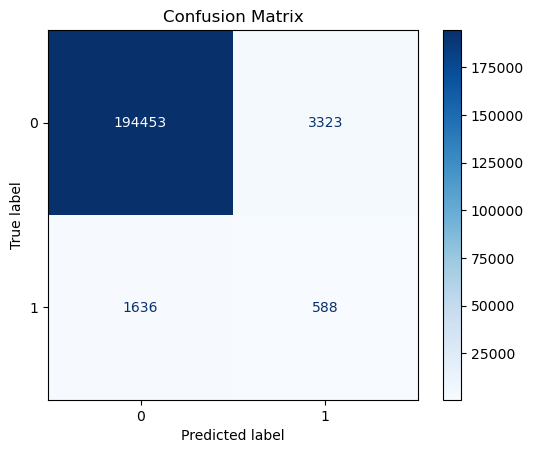

In [169]:
# Ilustración de la matriz de confusíón de los resultados del modelo:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
disp.plot(cmap = 'Blues') 
plt.title('Confusion Matrix')
plt.show()

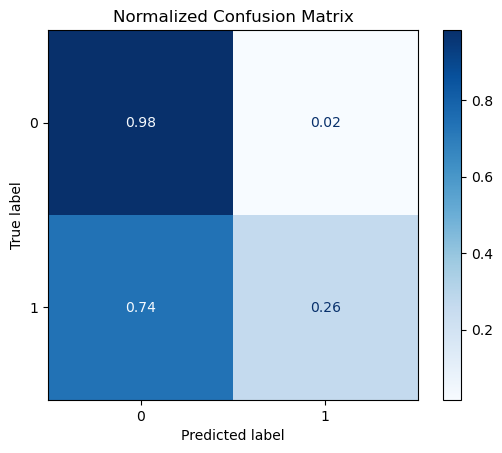

In [179]:
# Ilustración de una matriz de confusión normalizada para poder ver la proporcionalidad de los resultados ya que los 
# valores absolutos son más dificiles de entender que los porcentajes (además, la matriz de confusión normalizada ayuda a 
# que los colores se visualicen mejor):

normalized_conf_matrix = conf_matrix / conf_matrix.sum(axis = 1, keepdims = True)

disp = ConfusionMatrixDisplay(confusion_matrix = normalized_conf_matrix)
disp.plot(cmap='Blues', values_format=".2f")  # Use ".2f" to format values as percentages with two decimal places
plt.title('Normalized Confusion Matrix')
plt.show()

La matriz de confusión normalizada de arriba nos muestra lo mismo que la matriz de confusión anterior pero de una forma más visualmente entendible. Podemos ver que de la cantidad de fraudes en el conjunto de datos de "test", solo 26% han sido predecidos correctamente, y el resto han resultado siendo falsos negativos. Este resultado no es el ideal, ya que el ideal sería de clasificar a un 100% de los fraudes como fraudes, pero el resultado tampoco es demasiado malo, dado que hay un 26% de fraudes que si que son clasificados como fraude, un porcentaje mucho significativamente alto que si se usara un modelo de al azar.

De la misma manera podemos también ver que de la cantidad de no fraudes en "test", el 98% han sido predecidos correctamente como no fraude y el 2% han sido predecidos incorrectamente como fraudes (siendo falsos positivos). Este resultado es relativamente bueno, dado que hay pocas instancias sin fraude que son incorrectamente clasificadas como fraude.

### Curva ROC (Receiver Operating Characteristic):

In [50]:
# Visualizando la probabilidad de que cada instancia del conjunto de datos de test sea o no fraude (primera columan de 
# y_prod) o fraude (segunda columna de y_prob)
y_prob = clf.predict_proba(X_test)
y_prob

array([[0.94866063, 0.05133937],
       [0.97549974, 0.02450026],
       [0.97130619, 0.02869381],
       ...,
       [0.93390479, 0.06609521],
       [0.95566453, 0.04433547],
       [0.97900598, 0.02099402]])

In [54]:
# Aislando las probabilidades de fraude de cada instancia:
fraud_prob = y_prob[:, 1]
fraud_prob

array([0.05133937, 0.02450026, 0.02869381, ..., 0.06609521, 0.04433547,
       0.02099402])

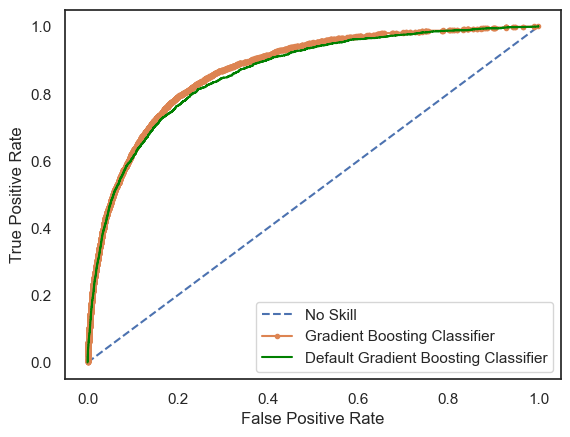

In [63]:
# Calculando la curva ROC del modelo final:
fpr, tpr, thresholds = roc_curve(y_test, fraud_prob) # change downsampled_y to y_train

# Ilustrando la curva ROC:
plt.plot([0,1], [0,1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'Gradient Boosting Classifier')
plt.plot(fpr_00, tpr_00, marker = ',', label = 'Default Gradient Boosting Classifier', color = "green")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [59]:
# Calculando el área debajo de la curva ROC del modelo de Gradient Boosting Classifier (curva de color naranja):
roc_auc = auc(fpr, tpr)
roc_auc

0.8726294329090567

En la curva ROC (Receiver Operating Characteristic) de arriba podemos ver representada la tasa de de verdaderos positivos frente a la tasa de falsos positivos para diferentes valores de thresholds. La linea diagonada azul punteada representa el rendimiento de un modelo hecho al azar, mientras que una curva con un codo lo más puntiagudo posible en la esquina de arriba a la derecha representaría un modelo con cerca de cero falsos negativos (y por lo tanto una precisión muy alta). En el case del modelo que hemos usado en este notebook, podemos ver que la curva podría acercarse más a la esquina de arriba a la derecha, o en otras palabras, tiene una precisión más alta que un modelo prediciendo al azar, pero tampoco tiene una precisión extremadamente alta. Esto también se puede observar al ver el valor AUC (Area Under Curve) de la curva, un valor que lo más cercano a uno lo mejor porque representaría una precisión más alta del modelo al predecir verdaderos positivos (en nuetro caso los positivos serían instancias de fraude).

In [243]:
# Calculando el valor de g-mean para cada threshold:
gmeans = np.sqrt(tpr * (1 - fpr))

In [244]:
# Localizando el indice con respecto al valor g-mean más alto:
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.255133, G-Mean=0.720


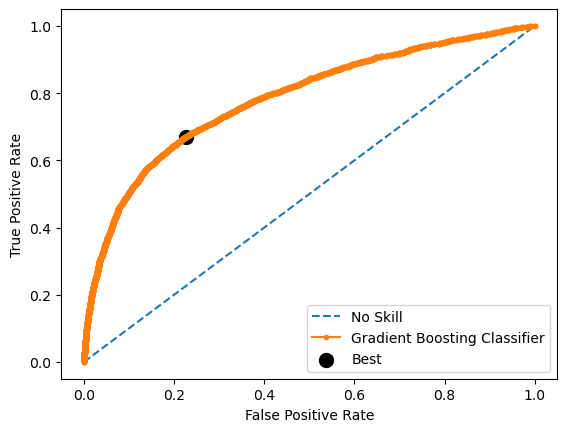

In [245]:
# Otra vez ilustrando el la curva ROC, pero esta vez mostrando el punto con el mejor threshold y mayor valor g-mean:
plt.plot([0,1], [0,1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'Gradient Boosting Classifier')
plt.scatter(fpr[ix], tpr[ix], s = 100, marker = 'o', color = 'black', label = 'Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

El gráfico de arriba nos muestra la misma curva naranja de ROC que el gráfico anterior excepto que ahora tenemos ilustrado el threshold más ideal para conseguir la precisión maxima. En nuestro caso, este threshold es de 0.255133, que significa que para conseguir la mayor cantidad de verdaderos fraudes y la menor cantidad de falsos fraudes, lo ideal sería considerar que una instancia va a ser fraude si tiene una probabilidad de más de 25.5% de serlo. Es importante mencionar que el threshold ideal cambia dependiendo de la métrica se esté maximizando, por lo tanto, este threshold solo funciona para obtener el máximo valor de g-mean del modelo.

### Curva PRC (Precision-Recall Curve):

In [271]:
# Obteniendo todos los parámetros necesarios para ilustrar un gráfico de PRC:

precision, recall, thresholds = precision_recall_curve(y_test, fraud_prob)

denominator = precision + recall
fscore = np.where(denominator != 0, 2 * precision * recall / denominator, 0.0)

Best Threshold=0.834249, F-Score=0.148


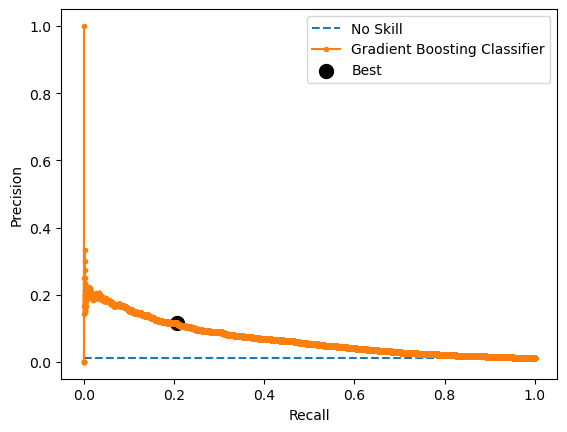

In [276]:
# Obteniendo el threshold ideal para obtener el f-score máximo:
ix = np.argmax(fscore) # change to f_score
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# Ilustrando la curva de PRC:
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0,1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.plot(recall, precision, marker = '.', label = 'Gradient Boosting Classifier')
plt.scatter(recall[ix], precision[ix], s = 100, marker = 'o', color = 'black', label = 'Best')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

La curva de PRC (Precision-Recall Curve) representa la relación entre la precisión y el recall. Hay que mencionar que la precisión se refiere a la proporción de verdaderos fraudes del total de fraudes predecidos por el modelo (TP / (TP + FP)) mientras que el recall se refiere a la proporción de fraudes que ha podido predecir el modelo (TP / (TP + FN)). Lo ideal sería que no solo estuviera la precisión lo más alto posible, sino que también estuviera el recall lo más alto posible, pero, como se puede ver en el gráfico de PRC, hay un patrón en el que cuando sube la precisión tiende a bajar el recall y vice versa. Esto es dado a que cuando se usa un threshold más alto, el modelo se vuelve más conservador al asignar instancias de fraude, y por lo tanto, aunque baje la cantidad de falsos positivos (incrementando la precisión), también causa que suba la cantidad de falsos negativos (bajando el valor de recall). Lo opuesta pasaría si se bajara el valor de threshold. De esta manera, podemos intuir que lo ideal sería un threshold dónde haya un valor relativamente alto de recall sin que haya una precisión demasiado baja. En nuestra caso, al haber buscado el threshold ideal para conseguir un valor de f1 más alto, el threshold ideal ilustrado es de 0.834249.

In [277]:
# El modelo de Gradient Boosting Classifier que hemos usado da este valor de f1:
score = f1_score(y_test, y_pred)
print('F-Score: %.5f' % score)

F-Score: 0.19169


### Curva de Ganancia Acumulada (Cumulative Gains Curve):

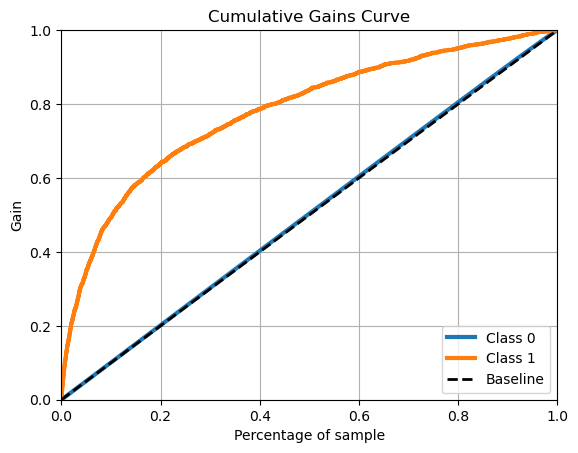

In [254]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob)
plt.show()

En la curva de ganancia cumulada se puede observar que revisando un 50% de los casos, el modelo seia rcapaz de detectar el 80% de los casos clasificados como fraudulentos. Revisando en torno al 70-75%, el modelíao ser capaíz de detectar el 90% de los casos. Estaón información es muy útil y valiosa ya que nos muestra en términos de costeel esfuerzo que se realiza para detectar fraudes, y así poder fijar un límite en función de objetivos y necesidades.

### Curva de Lift:

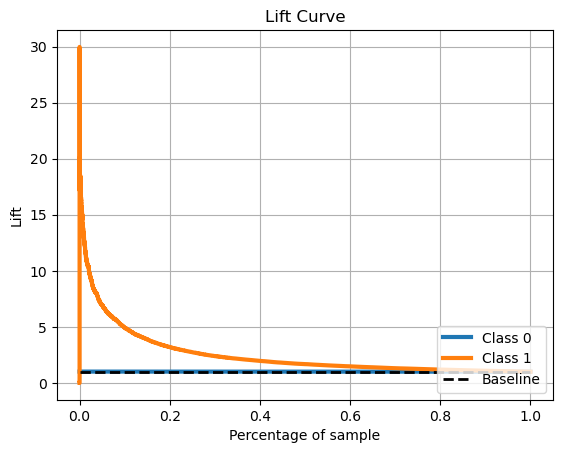

In [255]:
skplt.metrics.plot_lift_curve(y_test, y_prob)
plt.show()

A pesar de que la curva está ppr encima de "baseline", que es un modelo toalmente aleatorio y se encuentra por defecto, ha costado tener un buen rendimiento para la clase 1, no siendo la curva más óptima para que el modelo sea totalmente fiable y eficaz en su rendimiento.